## Binary classification tutorial
### LOS / NLOS classification 

This is a binary classification tutorial for beginners.  
Our goal is to classify whether UWB samples were collected in LOS or NLOS environments.

#### 1. Dataset
First, lets load all the dataset files from the dataset directory.

In [185]:
import pandas as pd
import glob

files = glob.glob('./dataset/*.csv')
print('Files in dataset directory:\n', files)
datasets = []
for file in files:
    dataset = pd.read_csv(file)
    datasets.append(dataset)
raw_dataset = pd.concat(datasets)

Files in dataset directory:
 ['./dataset/uwb_dataset_part6.csv', './dataset/uwb_dataset_part3.csv', './dataset/uwb_dataset_part1.csv', './dataset/uwb_dataset_part7.csv', './dataset/uwb_dataset_part2.csv', './dataset/uwb_dataset_part5.csv', './dataset/uwb_dataset_part4.csv']


Then let's take a quick skim through the data set

In [186]:
raw_dataset.shape

(42000, 1031)

There are 42000 samples with 1031 columns.  
What columns does it has?

In [187]:
raw_dataset.columns # all the columns

Index(['NLOS', 'RANGE', 'FP_IDX', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3',
       'STDEV_NOISE', 'CIR_PWR', 'MAX_NOISE', 'RXPACC',
       ...
       'CIR1006', 'CIR1007', 'CIR1008', 'CIR1009', 'CIR1010', 'CIR1011',
       'CIR1012', 'CIR1013', 'CIR1014', 'CIR1015'],
      dtype='object', length=1031)

In [188]:
raw_dataset.columns[:20] # first 20 columns

Index(['NLOS', 'RANGE', 'FP_IDX', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3',
       'STDEV_NOISE', 'CIR_PWR', 'MAX_NOISE', 'RXPACC', 'CH', 'FRAME_LEN',
       'PREAM_LEN', 'BITRATE', 'PRFR', 'CIR0', 'CIR1', 'CIR2', 'CIR3', 'CIR4'],
      dtype='object')

So, it has a NLOS column that indicates the sample is NLOS sample, measured range, ..., and extras.  
But it's hard to know the details about the columns.  
Please refer to https://github.com/ewine-project/UWB-LOS-NLOS-Data-Set to know more about the dataset [1].  

In breif, the samples were gathered in 7 different indoor environments using DecaWave DWM1000 UWB radio module.  
In each environment, 3000 LOS samples and 3000 NLOS samples were gathered, so there are 42000 samples.  

Elements:  
NLOS: 1 if NLOS, 0 if LOS  
RANGE: Measured range  
FP_IDX: Index of detected first path  
FP_AMP1: Point 1 of the first path amplitude  
FP_AMP2: Point 2 of the first path amplitude  
FP_AMP3: Point 3 of the first path amplitude  
STDEV_NOISE: Standard deviation of noise  
CIR_PWR: Total channel impluse response (CIR) power  
MAX_NOISE: Maximum value of noise  
RXPACC: Received rx preamble symbols  
CH: channel number  
FRAME_LEN: Length of the frame  
PREAM_LEN: Lenght of the preamble  
BITRATE: Bit rate (Kbps?)  
PRFR: Pulse repetition frequency rate in MHz  
CIR[0~1025]:Absolute value of channel impulse response 

We will set NLOS as a target (y) and set input dataset (X) which excludes target. 

Next, before look through the dataset, we need to split train and test data from the dataset.  
Then, we will only analyze the training data to prevent information leakage of the test set.

In [189]:
from sklearn.model_selection import train_test_split

y = raw_dataset['NLOS']
X = raw_dataset.drop(['NLOS'], axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=123)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(33600, 1030) (33600,) (8400, 1030) (8400,)


Let's take a look 5 samples from the raw dataset and check the values up to the PRFR columns.

In [190]:
import numpy as np
np.random.seed(123) # setting random seed for the reproducibility

training_set = pd.concat([train_y, train_X], axis=1)

training_set.sample(5).iloc[:, :15]

,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,CH,FRAME_LEN,PREAM_LEN,BITRATE,PRFR
3895,0.0,5.40,746.0,7573.0,17297.0,13154.0,92.0,7777.0,1414.0,474.0,2.0,27.0,1024.0,110.0,64.0
3509,1.0,6.01,747.0,2846.0,4855.0,4360.0,72.0,2695.0,1096.0,1024.0,2.0,39.0,1024.0,110.0,64.0
2483,0.0,7.23,751.0,6101.0,15313.0,19279.0,52.0,11622.0,789.0,667.0,2.0,27.0,1024.0,110.0,64.0
507,1.0,3.33,749.0,9298.0,16649.0,12920.0,112.0,6030.0,1698.0,707.0,2.0,27.0,1024.0,110.0,64.0
1363,1.0,7.10,751.0,7143.0,16598.0,17640.0,68.0,20720.0,1019.0,720.0,2.0,27.0,1024.0,110.0,64.0


We can check dataset's statistics easily by using pandas describe method

In [191]:
training_set.describe().iloc[:, 1:15]

,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,CH,FRAME_LEN,PREAM_LEN,BITRATE,PRFR
count,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.000000,33600.0,33600.000000,33600.000000,33600.0,33600.0
mean,3.836117,745.651369,8125.400298,11413.507232,9728.609107,72.234048,9787.853958,1315.555149,616.343780,2.0,33.782917,1043.367619,110.0,64.0
std,2.357337,4.510710,5393.366217,6240.553631,5358.781395,29.159301,4914.140688,579.464117,307.174686,0.0,5.948739,97.680091,0.0,0.0
min,0.000000,707.000000,7.000000,63.000000,187.000000,28.000000,0.000000,310.000000,133.000000,2.0,27.000000,1024.000000,110.0,64.0
25%,1.810000,744.000000,3571.750000,5293.500000,4710.750000,56.000000,6734.000000,961.000000,318.000000,2.0,27.000000,1024.000000,110.0,64.0
50%,3.485000,746.000000,7119.500000,12286.000000,10240.000000,68.000000,9963.000000,1135.000000,513.000000,2.0,39.000000,1024.000000,110.0,64.0
75%,5.420000,748.000000,12280.000000,17303.000000,14260.250000,80.000000,12442.000000,1487.000000,1024.000000,2.0,39.000000,1024.000000,110.0,64.0
max,15.430000,848.000000,20572.000000,20612.000000,20577.000000,324.000000,37130.000000,5077.000000,1056.000000,2.0,39.000000,1536.000000,110.0,64.0


It seems that FP_AMP2 is highset values among FP_AMP 1, 2, 3 and features about amplitude have high standard deviation.  
Also, some features like CH and BITRATE seem useless, because all samples have same value of these features.    
Interestingly, it seems like most of the FRAME_LEN and PREAM_LEN values are same while there seem to be a few exceptional values.  

Let's examine how many unique values each feature has

In [192]:
training_set.nunique()[:15]

NLOS               2
RANGE           1146
FP_IDX            69
FP_AMP1        15445
FP_AMP2        15261
FP_AMP3        15459
STDEV_NOISE       75
CIR_PWR        15186
MAX_NOISE       2886
RXPACC           722
CH                 1
FRAME_LEN          3
PREAM_LEN          2
BITRATE            1
PRFR               1
dtype: int64

CH, BITRATE, and PRFR have only one unique value that we can ignore these features from the dataset because they have no useful information  
for distinguishing LOS/NLOS.  

Besides, we can see that min value of the CIR_PWR is 0 but it looks like outlier or fault value.

In [193]:
training_set[training_set['CIR_PWR']==0]

,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,...,CIR1006,CIR1007,CIR1008,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015
4343,1.0,7.02,757.0,30.0,214.0,413.0,36.0,0.0,412.0,192.0,...,252.0,271.0,190.0,292.0,271.0,239.0,210.0,260.0,223.0,256.0
1356,1.0,6.33,747.0,293.0,311.0,187.0,28.0,0.0,310.0,160.0,...,197.0,84.0,246.0,353.0,196.0,38.0,228.0,42.0,173.0,0.0


Above result shows that the samples which have 0 CIR_PWR are NLOS.  
We can drop these samples from the dataset, but leave it now for a while for the future analysis.

Let's dive deep into the other features later in the chapter data analysis.

### 2. Baseline

Let's reproduce baseline machine learning model and features in the paper:     
*Ferreira, André G., et al. "Feature selection for real-time NLOS identification and mitigation   
for body-mounted UWB transceivers." IEEE Transactions on Instrumentation and Measurement 70 (2021): 1-10*  [2].

With the baseline, it is easy to compare how new models or features help improve performance.  

The work in [2] use 14 features for the LOS/NLOS classification.  
We can also find 9 features in the dataset [1], but we need to add 5 more features.  
We will just implement 5 features in here without explanation, please refer to [2] who interested about features.

In [194]:
const_A = 121.74

temp_X = pd.concat([train_X, test_X]) # concat train_X and test_X for a while for adding new features

# estimated received signal strength
temp_X['PWR_RSS'] =  10.0 * np.log10(1+ temp_X['CIR_PWR']*pow(2,17) / pow(temp_X['RXPACC'], 2)) - const_A 
# estimated received power of the first path impulse
temp_X['PWR_FP'] = 10.0 * np.log10(1+ (pow(temp_X['FP_AMP1'], 2) + pow(temp_X['FP_AMP1'], 2) + pow(temp_X['FP_AMP1'], 2))
                                    / pow(temp_X['RXPACC'], 2)) - const_A
# ratio of Maximum noise and first path power
temp_X['RAT_MN_FP'] = temp_X['MAX_NOISE'] / temp_X['FP_AMP2']
# power difference between the estimated RSS and estimated power of the first path
temp_X['PWR_DIFF'] = temp_X['PWR_RSS'] - temp_X['PWR_FP']
# power ratio between the estimated power of the first path and estimated RSS
temp_X['PWR_RAT'] = temp_X['PWR_FP'] / temp_X['PWR_RSS']

# seperate it again by index
train_X, test_X = temp_X[:33600], temp_X[33600:]

Then, let's bulid a random forest classifier model which shows highest f1_score in [2].     
We train the model with the training samples with baseline's 14 features and predict test samples' LOS/NLOS with the trained model.

In [195]:
from sklearn.ensemble import RandomForestClassifier

baseline_features_14 = ['RANGE', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3', 'STDEV_NOISE',
                        'CIR_PWR', 'RXPACC', 'MAX_NOISE', 'FP_IDX',
                        'PWR_RSS', 'PWR_FP', 'RAT_MN_FP', 'PWR_DIFF', 'PWR_RAT']
                        
# same hyperparameters with [2] and set random_state for the reproducibility
baseline14_model = RandomForestClassifier(n_estimators=30, random_state=123)
# training
baseline14_model.fit(train_X[baseline_features_14], train_y)
# predicts LOS/NLOS using test samples
pred_y = baseline14_model.predict(test_X[baseline_features_14])

Then let's see f1_score of the baseline model with 14 features.

In [196]:
from sklearn.metrics import f1_score
baseline14_score = f1_score(test_y, pred_y)

print(baseline14_score)

0.9055649241146712


In [2], baseline model shows 0.97 f1 score but the result above shows about 0.905 f1 score.  
I think this performance degradation comes from the various enviromental setting.  
Because dataset [1] collected from 7 indoor environments while dataset in [2] collected from the same environment.

In addition, [2] showed that random forest classifier model which trained with the 4 features ('PWR_DIFF', 'FP_IDX', 'PWR_FP', 'FP_AMP2') achieves   
similar f1_score (0.97) with the model trained with the 14 features.  
So let's evluate it again with the model which trained with the 4 features.

In [197]:
baseline_features_4 = ['PWR_DIFF', 'FP_IDX', 'PWR_FP', 'FP_AMP2']

baseline4_model = RandomForestClassifier(n_estimators=30, random_state=123)
baseline4_model.fit(train_X[baseline_features_4], train_y)
pred_y = baseline4_model.predict(test_X[baseline_features_4])
baseline4_score = f1_score(test_y, pred_y)

print('baseline 4 f1 score:', baseline4_score)
print('baseline 14 f1 score:', baseline14_score)

baseline 4 f1 score: 0.8351865579441562
baseline 14 f1 score: 0.9055649241146712


In [2], where the dataset collected from the same environments, the performance of those two models are almost same.  
But, above result indicates that the 4 useful features are not enough to distinguishing LOS/NLOS in different environments scenarios. 

### 3. Data analysis

In the last section, baseline model showed reasonable performance (0.907 f1 score) with 14 features.  
But how can we know which features are informative and which ones hinder training?  

In [198]:
# 16 available features
features = ['RANGE', 'FP_IDX', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3',
            'STDEV_NOISE', 'CIR_PWR', 'MAX_NOISE', 'RXPACC', 'FRAME_LEN',
            'PREAM_LEN', 'PWR_RSS', 'PWR_FP', 'RAT_MN_FP', 'PWR_DIFF', 'PWR_RAT']
train_X = train_X[features]
training_set = pd.concat([train_y, train_X], axis=1)

#### 3-1. Correlation

One of the simplest things is check correlation which shows linear relationship among features.  
We can easily check the correlation using pandas corr method.  
Let's analysis all the available features except CIR [0-1025] features.

First, let's examine which feature is most correlated with the LOS, NLOS

In [199]:
training_set.corr()['NLOS'].sort_values(ascending=False)

NLOS           1.000000
RXPACC         0.732492
RANGE          0.460046
RAT_MN_FP      0.267259
PWR_DIFF       0.257420
PREAM_LEN      0.192405
PWR_RAT        0.185673
STDEV_NOISE    0.154848
FRAME_LEN      0.032973
MAX_NOISE     -0.198300
FP_IDX        -0.317989
CIR_PWR       -0.392459
FP_AMP1       -0.449160
FP_AMP3       -0.513674
FP_AMP2       -0.525156
PWR_FP        -0.611588
PWR_RSS       -0.714085
Name: NLOS, dtype: float64

It seems like features about power are important indicators of the NLOS.  
It shows that samples with low power tends to be NLOS sample.  
Futhermore, NLOS samples tend to receive many rx preamble symbols.  
The code below sort correlation values with absolute values.  

In [200]:
corr_scores = abs(training_set.corr()['NLOS']).sort_values(ascending=False)[1:] # save it for future use
corr_scores

RXPACC         0.732492
PWR_RSS        0.714085
PWR_FP         0.611588
FP_AMP2        0.525156
FP_AMP3        0.513674
RANGE          0.460046
FP_AMP1        0.449160
CIR_PWR        0.392459
FP_IDX         0.317989
RAT_MN_FP      0.267259
PWR_DIFF       0.257420
MAX_NOISE      0.198300
PREAM_LEN      0.192405
PWR_RAT        0.185673
STDEV_NOISE    0.154848
FRAME_LEN      0.032973
Name: NLOS, dtype: float64

We can also make a fancy correlation figure with seaborns and matplotlib libraries.

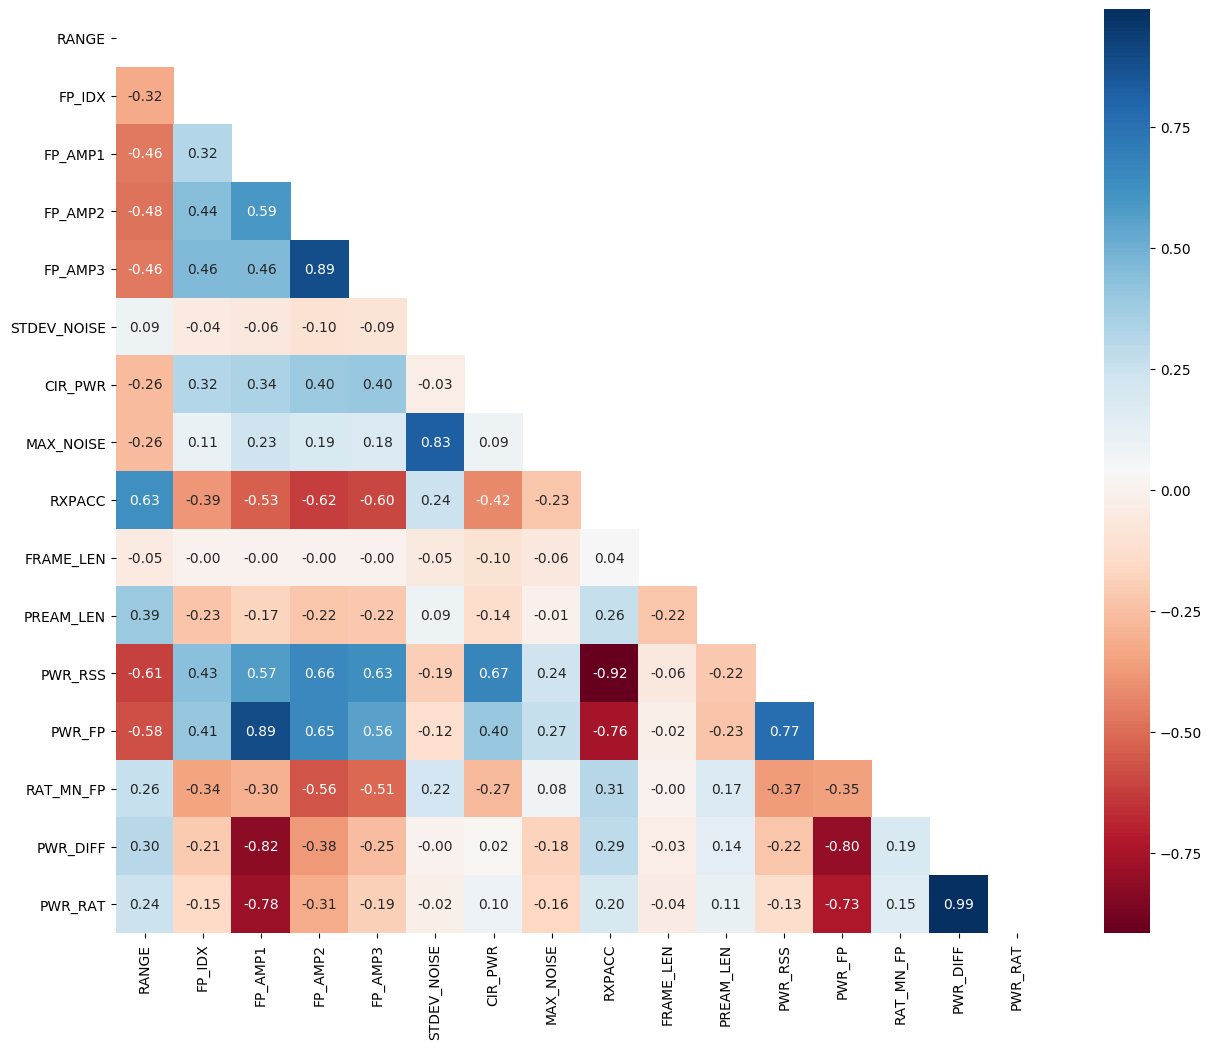

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

# mask is optional for removes upper triangle of the plot
mask = np.zeros_like(train_X.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 12))
ax = sns.heatmap(train_X.corr(), annot=True, fmt='.2f', mask=mask, cmap='RdBu')
ax.set_ylim(16, 0) # prevents heatmap row cut
plt.show()

If we just look at to the correlation values which higher than 0.8 or lower than -0.8, we can list  
FP_AMP3 <-> FP_AMP2: 0.89  
MAX_NOISE <-> STDEV_NOISE: 0.83  
PWR_RSS <-> RXPACC: -0.92  
PWR_FP <-> FP_AMP1: 0.89  
PWR_DIFF <-> FP_AMP1: -0.82  
PWR_DIFF <-> PWR_FP: -0.8  
PWR_RAT <-> PWR_DIFF: 0.99  

The result suggests that features about power correlated each other.  
Interestingly, 'PWR_RSS' and 'RXPACC' are highly correlated each other.

#### 3-2. Mutual information

Mutual information measure relationship between two quantities.  
While correlation only detects linear relationship, the mutual information can detect both linear and non-linear relationships.  
The least possible value of the mutual information is 0 and it indicates two features are independent.  
In theory, there is no upper bound, but values above 2.0 are uncommon.

Let's get mutual information score using sklearn mutual_info_classif (mutual_info_regression is for the real-value targets).

In [202]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = pd.Series(mutual_info_classif(train_X, train_y), index=train_X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)

PWR_RSS        0.337657
RXPACC         0.320622
PWR_FP         0.248041
CIR_PWR        0.165276
FP_AMP3        0.157897
FP_AMP2        0.151955
MAX_NOISE      0.141741
RANGE          0.138210
FP_AMP1        0.115731
FP_IDX         0.103765
STDEV_NOISE    0.098732
RAT_MN_FP      0.093433
PWR_DIFF       0.054727
PREAM_LEN      0.029594
PWR_RAT        0.028810
FRAME_LEN      0.000000
dtype: float64


Then print out the mutual information scores and correlation scores in descending order

In [203]:
print('Features    MI_score      Features Corr_score')
for mi_idx, mi_scr, corr_idx, corr_scr in zip(mi_scores.index, mi_scores, corr_scores.index, corr_scores):
    print(mi_idx.ljust(12), str(mi_scr)[:5], corr_idx.rjust(15),"  "+ str(corr_scr)[:5])

Features    MI_score      Features Corr_score
PWR_RSS      0.337          RXPACC   0.732
RXPACC       0.320         PWR_RSS   0.714
PWR_FP       0.248          PWR_FP   0.611
CIR_PWR      0.165         FP_AMP2   0.525
FP_AMP3      0.157         FP_AMP3   0.513
FP_AMP2      0.151           RANGE   0.460
MAX_NOISE    0.141         FP_AMP1   0.449
RANGE        0.138         CIR_PWR   0.392
FP_AMP1      0.115          FP_IDX   0.317
FP_IDX       0.103       RAT_MN_FP   0.267
STDEV_NOISE  0.098        PWR_DIFF   0.257
RAT_MN_FP    0.093       MAX_NOISE   0.198
PWR_DIFF     0.054       PREAM_LEN   0.192
PREAM_LEN    0.029         PWR_RAT   0.185
PWR_RAT      0.028     STDEV_NOISE   0.154
FRAME_LEN    0.0       FRAME_LEN   0.032


Baseline [2] uses 'PWR_DIFF', 'FP_IDX', 'PWR_FP', 'FP_AMP2' as best 4 features.  
But, it looks like there are more useful features we can take advantage of.

Futhermore the feature PREAM_LEN looks interesting because it has low mi_score but while has releatively high corr_score,  
and also it has only 2 unique values as we examined before (1024, 1536).

Let's make a barplot using preamble length and NLOS columns.

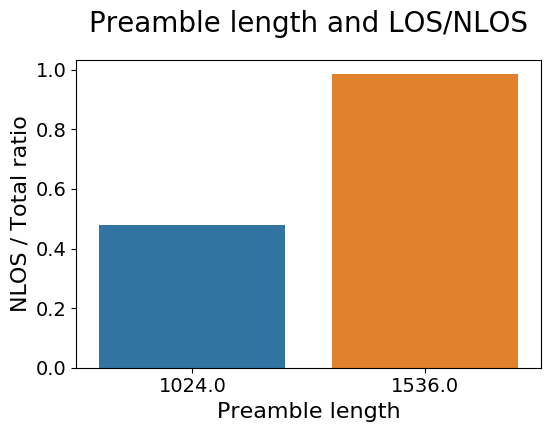

In [204]:
plt.figure(figsize=(6, 4))
sns.barplot(x = "PREAM_LEN", y = "NLOS", data=training_set,ci=None)

plt.title("Preamble length and LOS/NLOS", fontsize = 20, pad=20)
plt.xlabel("Preamble length", fontsize = 16)
plt.ylabel("NLOS / Total ratio", fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

It looks really awkward because the graph says almost every samples with 1536 preamble length is NLOS!  
Then how many samples with 1536 preamble length in the dataset?

In [205]:
training_set[training_set['PREAM_LEN']==1536].shape

(1271, 17)

1271 samples have 1536 preambles length. Then how many samples are LOS samples among them?  
We can also utilize query to pandas dataframe.

In [206]:
training_set.query("PREAM_LEN==1536 & NLOS==0").shape

(20, 17)

In [224]:
1 - (20/1271)

0.98426435877262

It shows that 98% of the samples with 1536 preamble length are NLOS samples.  
Then how about frame length?

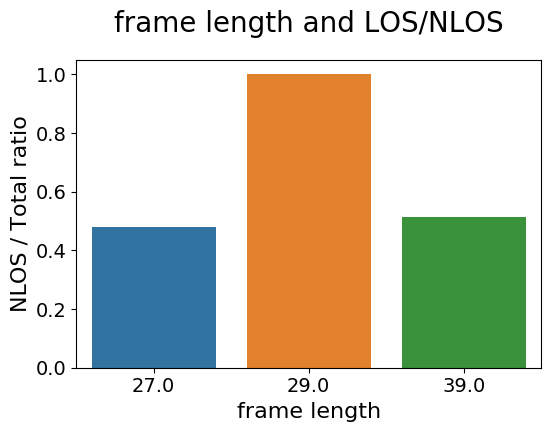

In [208]:
plt.figure(figsize=(6, 4))
sns.barplot(x = "FRAME_LEN", y = "NLOS", data=training_set,ci=None)

plt.title("frame length and LOS/NLOS", fontsize = 20, pad=20)
plt.xlabel("frame length", fontsize = 16)
plt.ylabel("NLOS / Total ratio", fontsize = 16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

It seems like frame length 29 can be a good indicator.
How many samples have 29 frame length?

In [209]:
training_set.query("FRAME_LEN==29")

,NLOS,RANGE,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,MAX_NOISE,RXPACC,FRAME_LEN,PREAM_LEN,PWR_RSS,PWR_FP,RAT_MN_FP,PWR_DIFF,PWR_RAT
3932,1.0,9.08,744.0,1666.0,2987.0,3825.0,52.0,851.0,772.0,364.0,29.0,1024.0,-92.482477,-103.688753,0.258453,11.206276,1.121172


There is just one sample.  
We can safely ignore FRAME_LEN feature because it has no useful information

In [210]:
features.remove('FRAME_LEN')
train_X = train_X[features]

#### 3-3. Permutation importance

Naturally, we are curious about the question *how much does each feature affect the model prediction?*  
Permutation importance randomly shuffle a single feature at a time, make a prediction with a trained model and then measures the performance.  
If the shuffled feature is important then the prediction performance will be poor, otherwise the performance will be similar.  

Permutation importance is fast to calculate and easy to understand.  
We can leverage eli5 library to calulate the permutation importance.

In [211]:
# !pip install eli5
import eli5

# First we need to split training data into data for fitting and data for validation
# This is to avoid using test data.
fit_X, val_X, fit_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=123)
 
# Next we need a pretrained model with considered features
my_model = RandomForestClassifier(n_estimators=30, random_state=123)
my_model.fit(fit_X, fit_y)

# Then calculates permutation importance with the trained model and not observed data
perm = eli5.sklearn.PermutationImportance(my_model, random_state=123).fit(val_X, val_y)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.2082 ± 0.0070,PWR_RSS
0.0882 ± 0.0050,RANGE
0.0204 ± 0.0029,RXPACC
0.0127 ± 0.0009,CIR_PWR
0.0120 ± 0.0028,MAX_NOISE
0.0083 ± 0.0038,FP_AMP3
0.0071 ± 0.0023,PWR_FP
0.0035 ± 0.0015,FP_AMP2
0.0029 ± 0.0011,RAT_MN_FP
0.0027 ± 0.0014,STDEV_NOISE


We can interpret the first number in each weight as performace degradation after the feature shuffle,   
and second number after +- sign as error because we evaluate each feature several times for validation.  
Above table shows that 'PWR_RSS', 'RANGE', 'RXPACC', 'CIR_PWR' and 'MAX_NOISE' have significant weights.

#### 3-4. Shap value

When we want to know how the model works for predictions, Shap values interpret the impact of features on the prediction.  
For example, When the 'PWR_RSS' value is high, does the model predict NLOS or LOS for this sample? If Los, How confident is the model about the prediction?  
We can answer these questions by interpreting shap values.

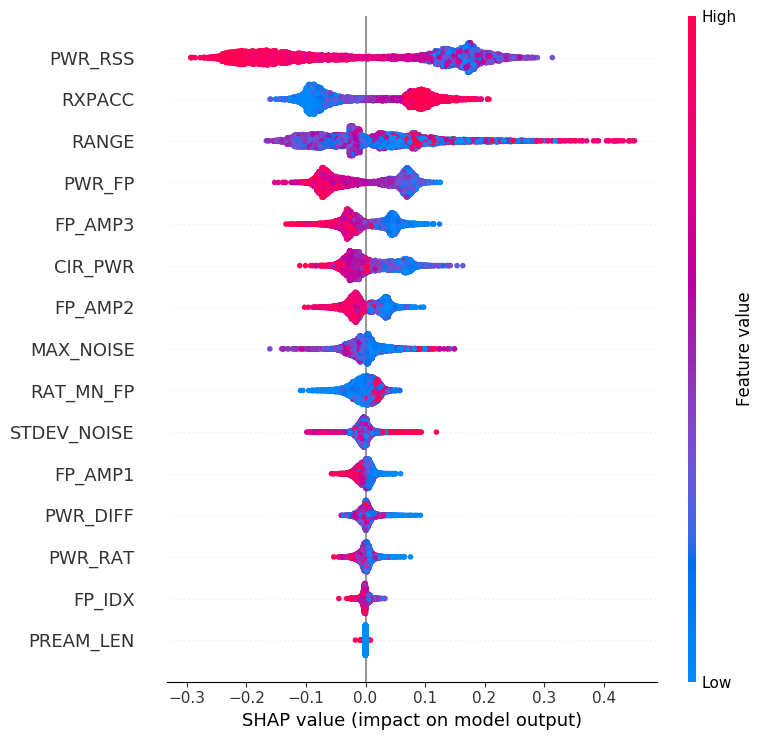

In [212]:
# !pip install git+https://github.com/slundberg/shap.git 
import shap  # package used to calculate Shap values

# Calculate shap values for all of test_X, it takes long time (about 4 minutes in Ryzen5700 CPU)
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(val_X)

# Make plot
shap.summary_plot(shap_values[1], val_X)

Above figure shows that when the value of 'PWR_RSS' is high, the model tends to predict this sample as LOS.  
Contrary, when the value of 'RANGE' is high, the model tends to predict this sample as NLOS.  

However, 'RANGE' samples look like messed up but the 'RANGE' has wide width.  
The wide width suggests that 'RANGE' has siginificant impact on the prediction and messed samples suggests that   
'RANGE' is interacting with other feature, but we don't know yet what other feature is interacting with 'RANGE'.  
Let's make a dependece plot with 'RANGE' and other feature.

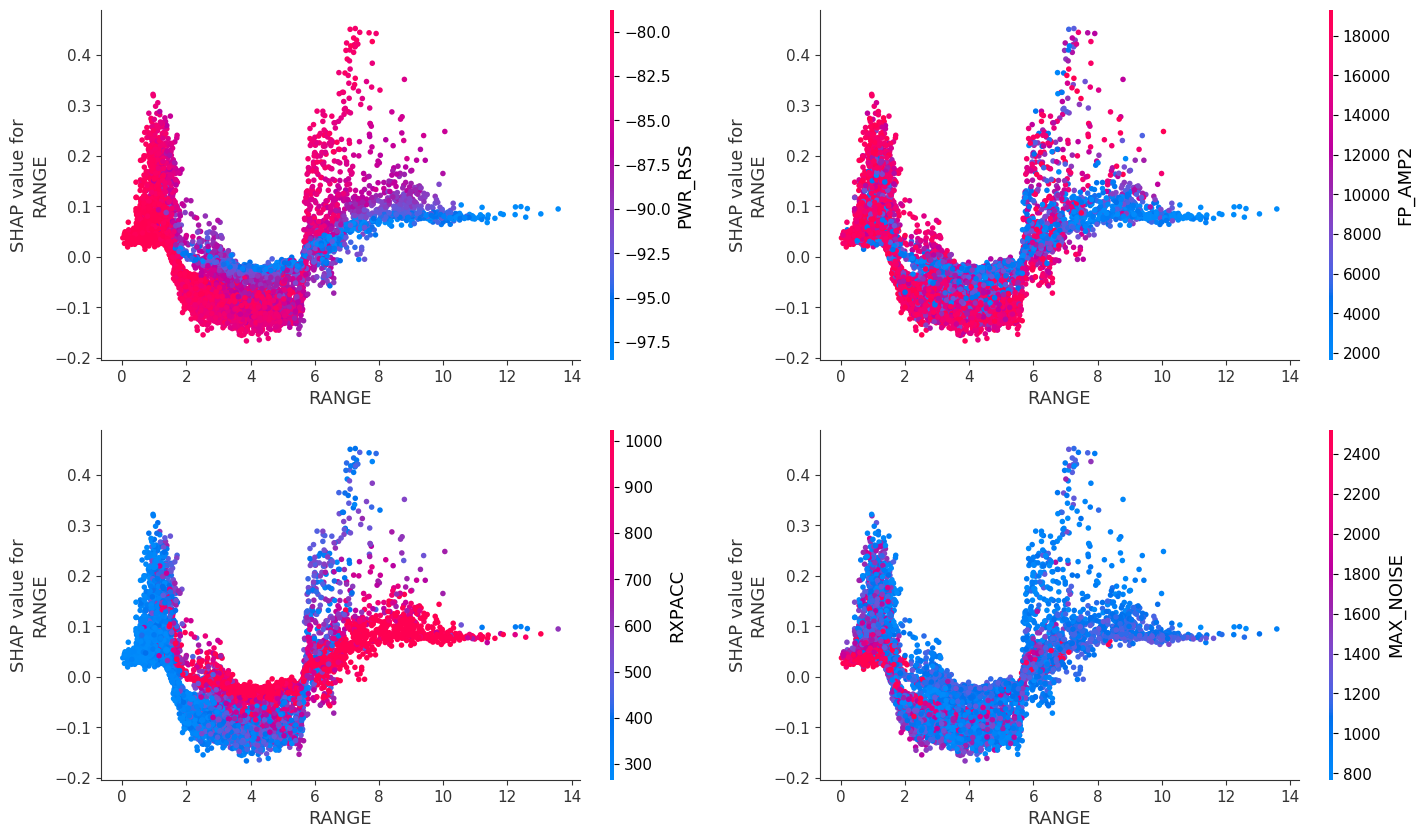

In [213]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))

shap.dependence_plot('RANGE', shap_values[1], val_X, interaction_index='PWR_RSS', ax=axs[0][0], show=False)
shap.dependence_plot('RANGE', shap_values[1], val_X, interaction_index='FP_AMP2', ax=axs[0][1], show=False)
shap.dependence_plot('RANGE', shap_values[1], val_X, interaction_index='RXPACC', ax=axs[1][0], show=False)
shap.dependence_plot('RANGE', shap_values[1], val_X, interaction_index='MAX_NOISE', ax=axs[1][1], show=False)

Now, we know what features are informative and various relationship among features.  
Let's pick 4 features and evaluate it.  
I choose 'PWR_RSS', 'RXPACC', 'RANGE' and 'MAX_NOISE' which seem important from the analysis in this chapter. 

In [214]:
my_features_4 = ['PWR_RSS', 'RXPACC', 'RANGE', 'MAX_NOISE']  

my_model_4 = RandomForestClassifier(n_estimators=30, random_state=123)
my_model_4.fit(train_X[my_features_4], train_y)
pred_y = my_model_4.predict(test_X[my_features_4])
score = f1_score(test_y, pred_y)

print('my score:', score, '\nbaseline 4 f1 score:', baseline4_score, '\nbaseline 14 f1 score:', baseline14_score)

my score: 0.8978417266187051 
baseline 4 f1 score: 0.8351865579441562 
baseline 14 f1 score: 0.9055649241146712


It looks pretty impressive.

### 4. Creating and evaluating features

Now, we have some insight about features by data analysis.  
In this chapter, we will create various features using informative features and then evaluate them.

Let's make a method that gets dataset and return f1 score for the feature evaluation

In [215]:
from sklearn.model_selection import cross_val_score

def score_dataset(X, y, model):
    score = cross_val_score(model, X, y, cv=5, scoring='f1') # metric: f1_score
    return score.mean()

Usually, plotting features can suggest mathematical data transformation.

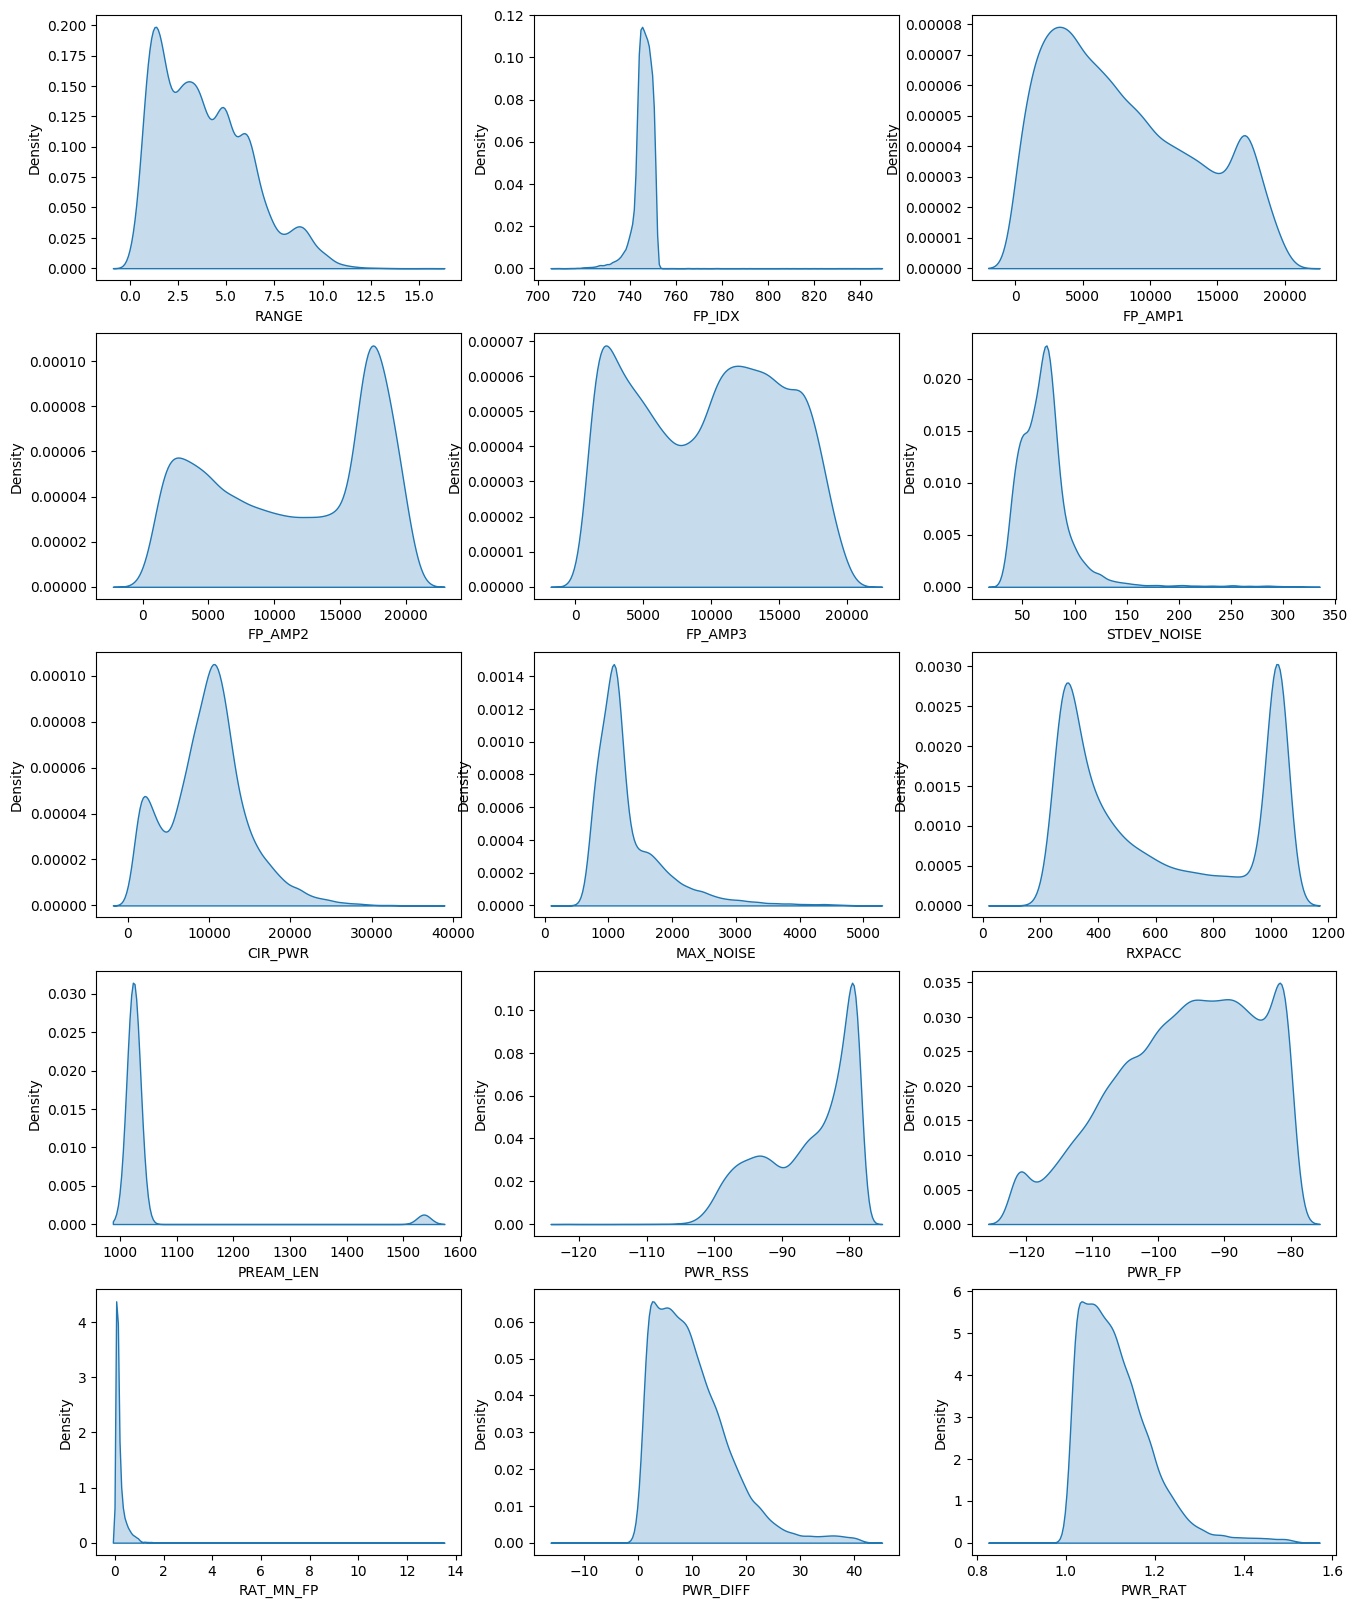

In [216]:
fig, axs = plt.subplots(5, 3, figsize=(16, 20))
for row in range(5):
    for col in range(3):
        sns.kdeplot(train_X.iloc[:,3*row+col], shade=True, ax=axs[row][col])

It looks like 'RAT_MN_FP' is too narrow to get useful information.  
Let's reshape this feature using numpy log method.

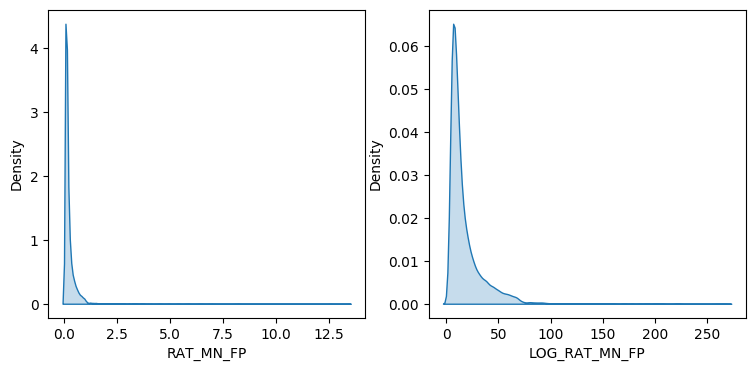

In [217]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
train_X["LOG_RAT_MN_FP"] = train_X['RAT_MN_FP'].apply(np.log1p) * 100
sns.kdeplot(train_X.RAT_MN_FP, shade=True, ax=axs[0])
sns.kdeplot(train_X.LOG_RAT_MN_FP, shade=True, ax=axs[1]);

It looks much better. Then, let's compare these feature with score_dataset method.

In [218]:
random_forest_model = RandomForestClassifier(n_estimators=30, random_state=123)
RAT_MN_FP_score = score_dataset(train_X[my_features_4+['RAT_MN_FP']], train_y, random_forest_model)
LOG_RAT_MN_FP_score = score_dataset(train_X[my_features_4+['LOG_RAT_MN_FP']], train_y, random_forest_model)
print(RAT_MN_FP_score, LOG_RAT_MN_FP_score)

0.9086829997491386 0.90865504476109


There is no dramatic difference. It's because tree based models are much less sensitive to input's scale than other models.  
Then how about SVM?

In [219]:
from sklearn.svm import SVC

# same parameter with [2]. It used default setting.
svm_model = SVC(random_state=123)
RAT_MN_FP_score = score_dataset(train_X[my_features_4+['RAT_MN_FP']], train_y, svm_model)
LOG_RAT_MN_FP_score = score_dataset(train_X[my_features_4+['LOG_RAT_MN_FP']], train_y, svm_model)
print(RAT_MN_FP_score, LOG_RAT_MN_FP_score)

0.839342237802747 0.842346735994909


Although the performance difference is not that large, there is an improvement unlike the random forest model.

From now, with base 4 feautures + LOG_RAT_MN_FP, we will add various features and evaluate the performance. 

In [225]:
# makes some simple features

my_features_5 = my_features_4 + ['LOG_RAT_MN_FP']

test_features_list = ['FP_IDX', 'FP_AMP1', 'FP_AMP2', 'FP_AMP3', 'STDEV_NOISE',
                      'CIR_PWR', 'PWR_FP', 'PWR_DIFF', 'RAT_1_2', 'RAT_1_3',
                      'RAT_2_3', 'DIFF_1_2', 'DIFF_1_3', 'DIFF_2_3']

train_X['RAT_1_2'] = train_X.FP_AMP1 / train_X.FP_AMP2
train_X['RAT_1_3'] = train_X.FP_AMP1 / train_X.FP_AMP3
train_X['RAT_2_3'] = train_X.FP_AMP2 / train_X.FP_AMP3
train_X['DIFF_1_2'] = train_X.FP_AMP1 - train_X.FP_AMP2
train_X['DIFF_1_3'] = train_X.FP_AMP1 - train_X.FP_AMP3
train_X['DIFF_2_3'] = train_X.FP_AMP2 - train_X.FP_AMP3

train_X.head()[test_features_list]

,FP_IDX,FP_AMP1,FP_AMP2,FP_AMP3,STDEV_NOISE,CIR_PWR,PWR_FP,PWR_DIFF,RAT_1_2,RAT_1_3,RAT_2_3,DIFF_1_2,DIFF_1_3,DIFF_2_3
4572,745.0,15937.0,16456.0,18459.0,52.0,12274.0,-87.469856,3.244761,0.968461,0.863373,0.891489,-519.0,-2522.0,-2003.0
2883,741.0,6739.0,4307.0,4423.0,92.0,8573.0,-100.569580,9.134060,1.564662,1.523626,0.973773,2432.0,2316.0,-116.0
3479,747.0,5077.0,5054.0,10837.0,52.0,14059.0,-93.220811,13.765433,1.004551,0.468488,0.466365,23.0,-5760.0,-5783.0
4084,744.0,5672.0,4509.0,3555.0,68.0,9363.0,-102.053133,11.000093,1.257929,1.595499,1.268354,1163.0,2117.0,954.0
2067,744.0,17917.0,18059.0,11822.0,52.0,8164.0,-80.465854,0.457578,0.992137,1.515564,1.527576,-142.0,6095.0,6237.0


Let's evaluate those features.

In [221]:
score_dict = {} # python dictionary data structure

for new_feature in test_features_list:
    score_dict[new_feature] = score_dataset(train_X[my_features_5+[new_feature]], train_y, random_forest_model)

print("Features scores!")
for feature, score in sorted(score_dict.items(), key=lambda score_dict: score_dict[1], reverse=True):
    print(feature.ljust(13), score)

Features scores!
PWR_DIFF      0.9104699632545088
FP_AMP1       0.910398851859157
PWR_FP        0.9103886809894952
DIFF_1_2      0.909845046688066
RAT_1_2       0.9096084939982159
RAT_1_3       0.9086920952447253
RAT_2_3       0.9086669028906085
FP_AMP3       0.9082796669386746
FP_IDX        0.9081612999812165
STDEV_NOISE   0.9077951071720876
DIFF_1_3      0.9075472828402903
CIR_PWR       0.9075341176291349
DIFF_2_3      0.9074474198347415
FP_AMP2       0.9064970983339803


It looks like 'PWR_DIFF' feature helps improve performance.  
Let's add 'PWR_DIFF' to my_features and do it again to add one more feature. 

In [226]:
my_features_6 = my_features_5 + ['PWR_DIFF']
test_features_list.remove('PWR_DIFF')
 
for new_feature in test_features_list:
    score_dict[new_feature] = score_dataset(train_X[my_features_6+[new_feature]], train_y, random_forest_model)

print("Features scores!")
for feature, score in sorted(score_dict.items(), key=lambda score_dict: score_dict[1], reverse=True):
    print(feature.ljust(13), score)

Features scores!
FP_AMP3       0.9106789556397695
CIR_PWR       0.9100590101914857
RAT_2_3       0.9096486228612719
STDEV_NOISE   0.9095228252669431
FP_IDX        0.9094778145314812
DIFF_1_2      0.9091329162176789
DIFF_2_3      0.9089042681413103
DIFF_1_3      0.9088011214532734
FP_AMP1       0.9085793252986833
RAT_1_3       0.9083708790463636
PWR_DIFF      0.9083674935427796
RAT_1_2       0.9082664368984247
FP_AMP2       0.9081920784694075
PWR_FP        0.9073399117959932


Let's add 'FP_AMP3' as a new feature.  
Now, It's time to evaluate newly selected features with the test dataset.  

In [227]:
my_features_7 = my_features_6 + ['FP_AMP3']

# add new features to the test set
test_X["LOG_RAT_MN_FP"] = test_X['RAT_MN_FP'].apply(np.log1p) * 100

num_features = 4
my_model = RandomForestClassifier(n_estimators=30, random_state=123)
for features in [my_features_4, my_features_5, my_features_6, my_features_7]:
    my_model.fit(train_X[features], train_y)
    pred_y = my_model.predict(test_X[features])
    score = f1_score(test_y, pred_y)
    print('my model ' + str(num_features) + ' score:', score)
    num_features += 1
    
print('baseline 4 f1 score:', baseline4_score, '\nbaseline 14 f1 score:', baseline14_score)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


my model 4 score: 0.8978417266187051
my model 5 score: 0.9076498138585325
my model 6 score: 0.907516536380036
my model 7 score: 0.9097888675623801
baseline 4 f1 score: 0.8351865579441562 
baseline 14 f1 score: 0.9055649241146712


Above results show that only with 5 features, the model gets higher f1 score than baseline model with 14 features.  
But there are less performance improvement after 5 featurs and gap between baseline and my_model is very small.  
I encourages you to create and evaluate your own features to get higher performance!  

### 5. Model hyperparameter tuning

The hyperparameters of a model are set before the model training and they determins the behavior of the model.  
But it's hard to test every hyperparameters of the model because there are infinitely many settings available.  
As a good alternative, sklearn grid search helps finding best hyperparameters setting among user defined candidates.  
Let's find an appropriate number of the random forest's estimators.

In [240]:
from sklearn.model_selection import GridSearchCV, KFold

param = {'n_estimators': [n for n in range(10, 201, 20)]}
kf = KFold(random_state=123, n_splits=3, shuffle=True) # splits data into 3 folds
print(param)

model = RandomForestClassifier(random_state=123)
grid = GridSearchCV(estimator=model, param_grid = param, scoring = 'f1', cv=kf)
grid.fit(train_X[my_features_7], train_y)

{'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190], 'max_depth': [3, 5, 7, 9, None]}


GridSearchCV(cv=KFold(n_splits=3, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(random_state=123),
             param_grid={'max_depth': [3, 5, 7, 9, None],
                         'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150,
                                          170, 190]},
             scoring='f1')

In [242]:
print ('Achieved best score', grid.best_score_, 'with', grid.best_params_)

Achieved best score 0.9126980028036806 with {'max_depth': None, 'n_estimators': 110}


The result suggests that the random forest model with 110 estimators (trees) shows the best performance.  
Let's evaluate the performance with test set using the best model we got. 

In [244]:
pred_y = grid.best_estimator_.predict(test_X[my_features_7])
my_score = f1_score(test_y, pred_y)

print('baseline 14 f1 score:', baseline14_score)
print('my model 7 score: 0.9097888675623801')
print('best model 7 score:', my_score)

baseline 14 f1 score: 0.9055649241146712
my model 7 score: 0.9097888675623801
best model 7 score: 0.9122764910596424


We got slightly better performance with the best model.  
Besides, there are more hyperparameters that can be tuned for random forest classifier.  
Please refer to https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
for more information about random forest classifier.

### 6. Conclusion

We examined UWB LOS/NLOS dataset and applied data science & machine learning techniques to analysis the dataset.  
This notebook can be a good resource to start with your own research or study.  
Just reuse and apply the code snippets in this notebook to your own dataset.